In [35]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS

df = pd.read_csv('data/dataSentimen.csv')
df = df.head(1000)
df['sentimen'] = df['sentimen'].replace({
    'positive': 'positif',
    'negative': 'negatif',
    'neutral': 'netral'
})
df

,cleaned_text,sentimen
0,body ev buat bauksit juga milik indonesia ketu...,netral
1,baterai rupa komponen utama ev indonesia milik...,netral
2,indonesia milik semua komponen bahan dasar bua...,netral
3,ev rupa tongkat indonesia jadi dominasi dunia ...,netral
4,hadir spkkamu juga jadi perhati tamutamu negar...,netral
...,...,...
995,bamsoet puji upaya pertamina migrasi kendara k...,netral
996,kepala bkpm negosiasi tesla jalan ada putus te...,netral
997,pertamina usaha negara milik nilai aset sangat...,netral
998,eng kembang kendara listrik bisa tunggu energi...,netral


In [36]:
# Bersihkan data kosong/null
df = df.dropna(subset=['cleaned_text', 'sentimen'])
df = df[df['cleaned_text'].str.strip() != ""]

# Cek panjang teks
df['text_length'] = df['cleaned_text'].str.len()
print(df['text_length'].describe())

count    1000.000000
mean      113.016000
std        53.407697
min        15.000000
25%        65.000000
50%       107.000000
75%       157.250000
max       239.000000
Name: text_length, dtype: float64


## Visualization

In [37]:
tb_counts = df.sentimen.value_counts()
tb_counts

sentimen
netral     794
positif    143
negatif     63
Name: count, dtype: int64

<Axes: title={'center': 'Sentiment Analysis'}, xlabel='Sentimen', ylabel='Jumlah Tweet'>

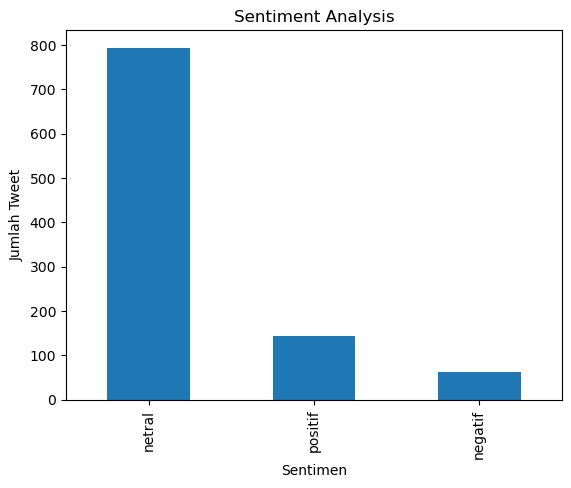

In [38]:
df['sentimen'].value_counts().plot(kind='bar', title='Sentiment Analysis', xlabel='Sentimen', ylabel='Jumlah Tweet')

In [39]:
data_negatif = df[df['sentimen'] == 'negatif']
data_positif = df[df['sentimen'] == 'positif']
data_netral = df[df['sentimen'] == 'netral']

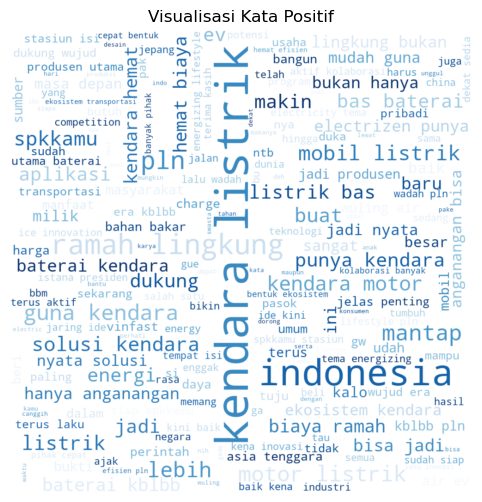

In [40]:
all_text_s1 = ' '.join(word for word in data_positif["cleaned_text"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Positif")
plt.margins(x=0, y=0)
plt.show()

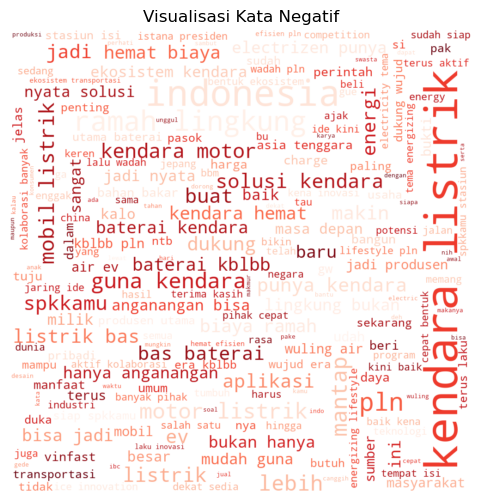

In [41]:
all_text_s2 = ' '.join(word for word in data_negatif["cleaned_text"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Negatif")
plt.margins(x=0, y=0)
plt.show()

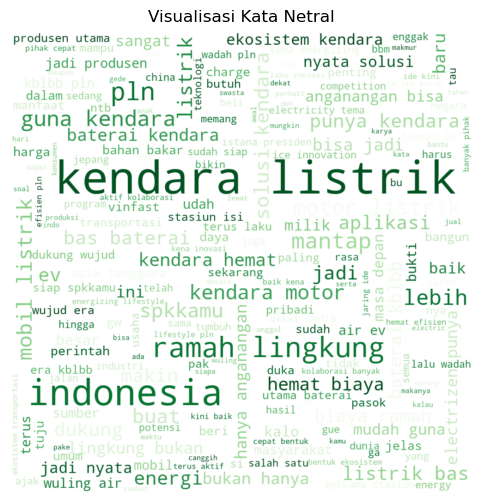

In [42]:
all_text_s3 = ' '.join(word for word in data_netral["cleaned_text"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Netral")
plt.margins(x=0, y=0)
plt.show()

## Spliting Data

In [43]:
# Encode label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentimen'])

In [44]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42
)

## Training Data Bert

In [45]:
# Load tokenizer dan model IndoBERT pre-trained untuk sequence classification
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [47]:
# Prepare datasets and loaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

In [48]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [49]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [50]:
# Training loop sederhana
def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation loop sederhana
def eval_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [51]:
# Training ringan (3 epoch)
EPOCHS = 3
train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, optimizer)
    val_acc = eval_model(model, val_loader)
    print(f"Train Loss: {train_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

Epoch 1/3


100%|██████████| 50/50 [03:22<00:00,  4.04s/it]


Train Loss: 0.5226 | Validation Accuracy: 0.8950
Epoch 2/3


100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


Train Loss: 0.2772 | Validation Accuracy: 0.8900
Epoch 3/3


100%|██████████| 50/50 [03:04<00:00,  3.68s/it]


Train Loss: 0.1668 | Validation Accuracy: 0.9200


## Evaluation

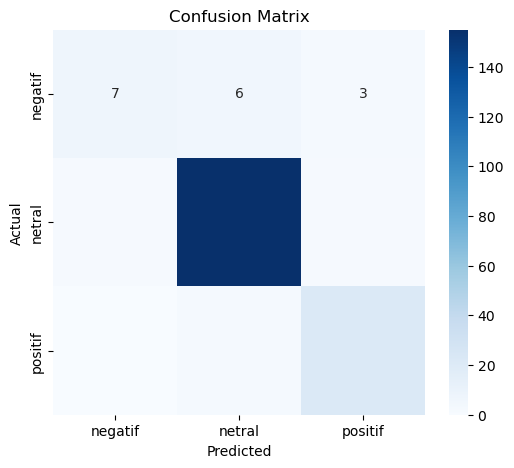

Classification Report:
               precision    recall  f1-score   support

     negatif       0.78      0.44      0.56        16
      netral       0.95      0.97      0.96       159
     positif       0.81      0.88      0.85        25

    accuracy                           0.92       200
   macro avg       0.85      0.76      0.79       200
weighted avg       0.92      0.92      0.91       200



In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def eval_model_full_report(model, data_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

# Setelah training selesai, panggil ini
eval_model_full_report(model, val_loader, label_encoder)